In [46]:
import json
from datasets import Dataset, load_dataset, load_metric
import pandas as pd
with open('/kaggle/input/uitds-fever-ise-publist-test/ise-dsc01-train_new.json', 'r') as file:
    datasets = json.load(file)

In [2]:
from huggingface_hub import notebook_login

notebook_login()

## Processed_train data

In [47]:
import re


def remove_author_from_context(context, author):
    if context.endswith(author):
        context = context[: -len(author)].strip()
    return context

def processed_based_data(datasets):
    new_datasets = {}
    for key, item in datasets.items():
        context = item['context']
        author_pattern = r"\n\n(.+)$"
        author_match = re.search(author_pattern, context)
    #     print(author_match)

        if author_match:
            author = author_match.group(1)
    #         print(author,"\n")
            if len(author) < 50:
                item['context'] = remove_author_from_context(context, author)
    #             print(author,'\n')
            if item['evidence'] is None:                  
                item['context'] = re.sub(r'\n\n', ' ', item['context'])
                item['context'] = " ".join(item['context'].split())

                new_datasets[key] = item
                continue
            if author in item['evidence']:
                continue

            item['evidence'] = re.sub(r'\n\n', ' ', item['evidence'])
            item['evidence'] = " ".join(item['evidence'].split())

            item['context'] = re.sub(r'\n\n', ' ', item['context'])
            item['context'] = " ".join(item['context'].split())

            new_datasets[key] = item
        else:
            # If no author found, just process evidence (if exists) and context
            if item['evidence'] is not None:
                item['evidence'] = re.sub(r'\n\n', ' ', item['evidence'])
                item['evidence'] = " ".join(item['evidence'].split())

            item['context'] = re.sub(r'\n\n', ' ', item['context'])
            item['context'] = " ".join(item['context'].split())

            new_datasets[key] = item
    return new_datasets


In [48]:
def extract_sentences_offcial(context):
    sentences = re.split(r'(?<![A-Z])\.\s+(?=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, A, Á, À, Ạ, Ả, Ã, Ậ, Ấ, Ầ, Ẫ, Ẩ, Â, Ặ, Ắ, Ằ, Ẵ, Ẳ, Ă, B, C, D, Đ, E, É, È, Ẹ, Ẻ, Ẽ, Ê, Ế, Ề, Ệ, Ể, Ễ, F, J, W, Z G, H, I, Ị, Ỉ, Í, Ì, Ĩ, K, L, M, N, O, Ó, Ỏ, Ò, Ọ, Õ, Ô, Ố, Ồ, Ỗ, Ộ, Ổ, Ơ, Ở, Ợ, Ờ, Ớ, Ỡ, P, Q, R, S, T, U, Ù, Ú, Ụ, Ủ, Ũ, Ư, Ứ, Ừ, Ử, Ự, Ữ, V, X, Y, Ỷ, Ỳ, Ý, Ỹ, Ỵ, \\",“, \-,*])', context)
    context_sentences = [sentence.strip() for sentence in sentences if sentence.strip()]  # Tách các câu trong context
    return context_sentences

In [49]:
datasets = processed_based_data(datasets)

In [50]:
for key, item in datasets.items():
    item['id'] = key
    item['context'] = item['context'].replace("…","... ")
    item['context'] = item['context'].replace("\""," \"")
    item['context'] = item['context'].replace("Dr","DR")
    
    context = item['context']
#     context = context.replace("…",". ")
#     if item['evidence'] is not None:
#         item['evidence_start'] = context.find(item['evidence'])

In [51]:
len(datasets)

37403

In [52]:
# datasets['7125']

In [53]:
# data = datasets['41604']

In [54]:
# temp = extract_sentences_offcial(data['context'])

In [55]:
# temp

* delete claim có trong context nhưng evidence không phải câu đó

In [56]:
keys_to_delete = []
for key, item in datasets.items():
    if item['evidence'] is None:
        continue
    if item['claim'] in item['context'] and item['claim'] not in item['evidence']:
        keys_to_delete.append(key)

for key in keys_to_delete:
    del datasets[key]

In [57]:
len(datasets)

36844

In [58]:
refutes_data = []
support_data = []
not_enough_data = []

for key, item in datasets.items():
    verdict = item['verdict']
    if verdict == 'REFUTED':
        refutes_data.append(item)
    elif verdict == 'SUPPORTED':
        support_data.append(item)
    elif verdict == 'NEI':
        not_enough_data.append(item)

In [59]:
len(refutes_data)

12458

In [60]:
dataset_2_class = refutes_data[:1000] + refutes_data[5000:6000] + refutes_data[10000:11000]  + support_data[:1000] + support_data[5000:6000] + support_data[10000:11000] + not_enough_data[:1000] + not_enough_data[5000:6000]+ not_enough_data[10000:11000]

In [61]:
len(dataset_2_class)

9000

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def get_similarity_with_TF_IDF_Sklearn(claim, evidence):
    
    # Tạo một TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer()

    # Biểu diễn câu thành vector TF-IDF
    tfidf_matrix = tfidf_vectorizer.fit_transform([claim, evidence])

    # Tính toán cosine similarity
    cosine_sim = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])

    return cosine_sim[0][0]

In [63]:
from tqdm.auto import tqdm
# lst_nei_score_trans = []
lst_sp_score_trans = []
lst_rf_score_trans = []

# lst_nei_score_sklearn = []
lst_sp_score_sklearn = []
lst_rf_score_sklearn = []


for i in tqdm(range(len(dataset_2_class))):
    if dataset_2_class[i]['verdict'] == 'NEI':
        continue
    claim = dataset_2_class[i]['claim']
    evidence = dataset_2_class[i]['evidence']
#     transformers_score = get_similarity_transformers_similarity_gpu(claim, evidence, tokenizer_of_processdata, model_of_processdata)
    sklearn_score = get_similarity_with_TF_IDF_Sklearn(claim, evidence)
    
#         lst_nei_score_sklearn.append(sklearn_score)
#         lst_nei_score_trans.append(transformers_score)
    if dataset_2_class[i]['verdict'] == 'SUPPORTED':
        lst_sp_score_sklearn.append(sklearn_score)
#         lst_sp_score_trans.append(transformers_score)
    else:
        lst_rf_score_sklearn.append(sklearn_score)
#         lst_rf_score_trans.append(transformers_score)

  0%|          | 0/9000 [00:00<?, ?it/s]

In [64]:
cnt = []
for i in range(len(lst_sp_score_sklearn)):
    if lst_sp_score_sklearn[i] <= min(lst_sp_score_sklearn) + 0.05:
        cnt.append(dataset_2_class[i]['id'])
#         print(f'------{cnt}------\n')
#         print(f"ID: {df['id'][i]}\nClaim: {df['claim'][i]}\nEvidence: {df['evidence'][i]}")
#         print(f'-----------------\n')


In [65]:
len(cnt)

14

In [66]:
dataset_2_class =[dataset_2_class[i] for i in range(len(dataset_2_class)) if dataset_2_class[i]['id'] not in cnt]

In [67]:
len(dataset_2_class)

8986

In [68]:
!pip install transformers sentence-transformers numpy

In [69]:
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer, util
import numpy as np
import torch

In [70]:
phobert_model_name = "vinai/phobert-base"
tokenizer = AutoTokenizer.from_pretrained(phobert_model_name)
model = AutoModel.from_pretrained(phobert_model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [71]:
import torch
from torch.cuda.amp import autocast
from tqdm.auto import tqdm

def process_data_with_gpu(data, tokenizer, model, max_context_sentences=6):
    # Đảm bảo GPU có sẵn
    device = torch.device("cuda")
    model = model.to(device)

    processed_data = []

    for item in tqdm(data):
        claim = item['claim']
        context = item['context']
        claim_tokens = tokenizer(claim, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            with autocast():  # Sử dụng autocast để tận dụng hiệu suất và giảm bộ nhớ
                claim_embedding = model(**claim_tokens).pooler_output

        # Di chuyển tensors lên CPU để thực hiện các phép toán NumPy
        claim_embedding = claim_embedding.to("cpu").numpy()

        # Chuyển các tensors về kiểu float32 (32-bit floating point)
        claim_embedding = claim_embedding.astype('float32')
        context_sentences = extract_sentences_offcial(context)# Tách các câu trong context
        best_similarity = 0.5  # Điểm tương đồng cao nhất
        # Câu có điểm tương đồng cao nhất
        best_sentence = []   
        for sentence in context_sentences:
            # Tiến hành nhúng câu
            similarity = []
            sentence_tokens = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True).to(device)
            with torch.no_grad():
                sentence_embedding = model(**sentence_tokens).pooler_output
            sentence_embedding = sentence_embedding.to("cpu").numpy()

            # Chuyển các tensors về kiểu float32 (32-bit floating point)
            sentence_embedding = sentence_embedding.astype('float32')

            # Tính độ tương tự với câu claim
            similarity_score = util.pytorch_cos_sim(claim_embedding, sentence_embedding)
            if len(context_sentences) <= max_context_sentences:
                similarity.append(similarity_score.item())
                similarity.append(sentence)
                best_sentence.append(similarity)
                continue 

            if similarity_score.item() > best_similarity:
                similarity.append(similarity_score.item())
                similarity.append(sentence)
                best_sentence.append(similarity)

        sorted_data = sorted(best_sentence, key=lambda x: x[0], reverse=True)
        top_data = sorted_data
        if len(top_data) <=6:
            context_end = context
        else:
            context_end = ". ".join([item[1] for item in top_data])
        
        data = {
            "context": context_end,
            "claim": claim,
            "verdict": item['verdict'],
            "evidence": item['evidence'],
            "id": item['id']
        }
        
        processed_data.append(data)

    return processed_data


In [72]:
dataset_2_class = process_data_with_gpu(dataset_2_class, tokenizer, model)

  0%|          | 0/8986 [00:00<?, ?it/s]

In [73]:
for item in dataset_2_class:
    if item['evidence'] is None:
        continue
    if item['evidence'] not in item['context']:
        item['context'] = item['context'] + ". "+ item['evidence']
    context = item['context']
    item['evidence_start'] = context.find(item['evidence'])

In [45]:
# dataset_2_class[0]

In [75]:
# import pandas as pd

# # ... Your previous code to calculate seq_len ...

# combined_text = []
# for item in dataset_2_class:
#     combined_text.append(item['context'])
# seq_len = [len(i.split()) for i in combined_text]
# chart = pd.Series(seq_len)
# print(chart)
# chart.hist(bins=30)
# min_seq_len = min(seq_len)
# print("Minimum sequence length:", min_seq_len)
# # Find and print the text strings with the minimum sequence length along with their indices
# min_seq_strings = [(i, s) for i, s in enumerate(combined_text) if len(s.split()) == min_seq_len]
# for i, s in min_seq_strings:
#     print(f"Index: {i}, Text with the minimum sequence length:", s)

# # Filter and keep data entries with a sequence length greater than or equal to 50
# processed_data = [item for i, item in enumerate(dataset_2_class) if seq_len[i] >= 120]

# # Print the first few entries in filtered_processed_data as an example
# for i, item in enumerate(processed_data[:5]):
#     print(f"Filtered Entry {i + 1}:")
#     print("Context:", item['context'])
#     print("Claim:", item['claim'])
#     print()


0       621
1       734
2       679
3       749
4       624
       ... 
8880    227
8881    229
8882    194
8883    243
8884    186
Length: 8885, dtype: int64
Minimum sequence length: 125


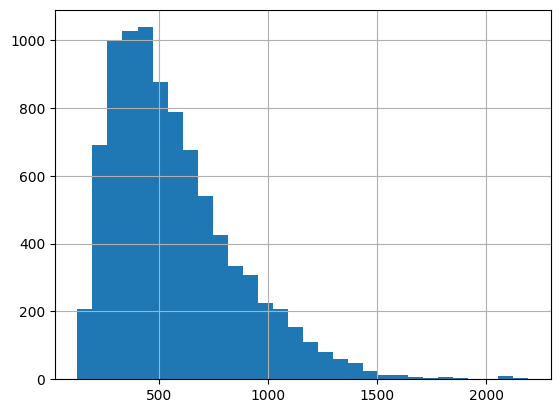

In [76]:
combined_text = []
for item in processed_data:
    combined_text.append(item['context'] + " " + item['claim'])
seq_len = [len(i.split()) for i in combined_text]
chart = pd.Series(seq_len)
print(chart)
chart.hist(bins=30)
min_seq_len = min(seq_len)
print("Minimum sequence length:", min_seq_len)

In [77]:
# processed_data[0]

In [78]:
answer =[]
start =[]
for item in processed_data:
    item['question'] = item.pop('claim')
    if item['evidence'] is None:
        item['answers'] = {
            'answer_start': [],
            'text': []      
        }
        item.pop('evidence')
        continue

    item['answers'] = {
        'answer_start': [item.pop('evidence_start')],
        'text': [item.pop('evidence')]      
    }

In [79]:
with open('/kaggle/working/data-processed-9000.json','w') as file:
    json.dump(processed_data,file)

In [ ]:
with open('/kaggle/input/data-2-class-processed-24k/wrong2.json','r') as file:
    processed = json.load(file)

In [ ]:
processed_data=[]
for i in processed:
    processed_data.append(i[0])

In [ ]:
processed_data[0]

In [80]:
from transformers import AutoTokenizer, XLMRobertaForQuestionAnswering
from transformers import AutoModelForQuestionAnswering
# from model.mrc_model import MRCQuestionAnswering
from datasets import load_dataset, load_metric

In [81]:
squad_v2 = True

In [82]:
model_checkpoint = "deepset/roberta-base-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [83]:
tokenizer.is_fast

True

In [84]:
test_data = processed_data

In [85]:
from sklearn.model_selection import train_test_split


# Tách dữ liệu thành tập train và tập test
train_data, val_data = train_test_split(processed_data, test_size=0.2, random_state=42)

In [86]:
val_data, test_data = train_test_split(val_data, test_size=0.5, random_state=42)

In [87]:
train_data = pd.DataFrame(train_data)

In [88]:
train_data.head()

,context,verdict,id,question,answers
0,Điểm cuốn hút của món này là cá hồi tươi ngon ...,REFUTED,33581,Điểm không cuốn hút của món gỏi cá hồi ngó sen...,"{'answer_start': [0], 'text': ['Điểm cuốn hút ..."
1,Ngay cả việc tải tài liệu từ nhiều website mà ...,REFUTED,32349,việc tải tài liệu từ nhiều website mà chưa đượ...,"{'answer_start': [0], 'text': ['Ngay cả việc t..."
2,Theo phát ngôn viên của Cơ quan Quản Lý Khí Qu...,SUPPORTED,35659,Rice cho biết trung bình 6 trường hợp cá voi l...,"{'answer_start': [839], 'text': ['""Chúng tôi g..."
3,"Chính sách hỗ trợ bao gồm cả khóa học trẻ em, ...",NEI,676,"Chính sách hỗ trợ bao gồm cả khóa học trẻ em, ...","{'answer_start': [], 'text': []}"
4,"Bác sĩ khuyến cáo khi có dấu hiệu đau bụng, nô...",REFUTED,21606,"Bác sĩ khuyến cáo khi có dấu hiệu đau bụng, nô...","{'answer_start': [0], 'text': ['Bác sĩ khuyến ..."


In [89]:
train_data = Dataset.from_pandas(train_data)

In [90]:
train_data

Dataset({
    features: ['context', 'verdict', 'id', 'question', 'answers'],
    num_rows: 7108
})

In [91]:
val_data = pd.DataFrame(val_data)

In [92]:
val_data = Dataset.from_pandas(val_data)

In [93]:
test_data = pd.DataFrame(test_data)

In [94]:
test_data = Dataset.from_pandas(test_data)

## Processed Data train

In [99]:
max_length = 512 # The maximum length of a feature (question and context)
doc_stride = 30

In [96]:
pad_on_right = tokenizer.padding_side == "right"

In [100]:
def prepare_train_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [101]:
train_dataset = train_data.map(
    prepare_train_features,
    batched=True,
    remove_columns=train_data.column_names,
)
len(train_data), len(train_dataset)

  0%|          | 0/8 [00:00<?, ?ba/s]

(7108, 45778)

In [102]:
validation_dataset = val_data.map(
    prepare_train_features,
    batched=True,
    remove_columns=val_data.column_names,
)
len(val_data), len(validation_dataset)

  0%|          | 0/1 [00:00<?, ?ba/s]

(888, 5760)

## Trainer API

In [ ]:
!pip install evaluate

In [103]:
model = XLMRobertaForQuestionAnswering.from_pretrained(model_checkpoint)

You are using a model of type roberta to instantiate a model of type xlm-roberta. This is not supported for all configurations of models and can yield errors.


In [104]:
from transformers import TrainingArguments

args = TrainingArguments(
    "XLM-processed-squadv2",
    evaluation_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    num_train_epochs=2,
    weight_decay=0.01,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    fp16=True,
#     save_strategy ='no',
    push_to_hub=True,
)

In [105]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
)
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,0.217300,0.229198
2,0.194600,0.238271


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



TrainOutput(global_step=22890, training_loss=0.2610287320931544, metrics={'train_runtime': 6176.0542, 'train_samples_per_second': 14.824, 'train_steps_per_second': 3.706, 'total_flos': 2.3923285859721216e+16, 'train_loss': 0.2610287320931544, 'epoch': 2.0})

In [106]:
trainer.save_model('XLM-processed-squadv2')

training_args.bin:   0%|          | 0.00/4.09k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/496M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

In [107]:
trainer.push_to_hub(commit_message="Training complete")

'https://huggingface.co/FuuToru/XLM-processed-squadv2/tree/main/'

In [108]:
stride=40

In [109]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [110]:
test_dataset = test_data.map(
    prepare_validation_features,
    batched=True,
    remove_columns=test_data.column_names,
)
len(test_data), len(test_dataset)

  0%|          | 0/1 [00:00<?, ?ba/s]

(889, 5527)

In [111]:
raw_predictions = trainer.predict(test_dataset)

In [112]:
# trained_checkpoint = "FuuToru/XLM-processed-squadv2"
# tokenizer = AutoTokenizer.from_pretrained(trained_checkpoint)
# trained_model = XLMRobertaForQuestionAnswering.from_pretrained(trained_checkpoint)

In [113]:
from tqdm.auto import tqdm
import collections

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 400):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []
        
        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}
        
        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        if not squad_v2:
            predictions[example["id"]] = best_answer["text"]
        else:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example["id"]] = answer

    return predictions

In [114]:
final_predictions = postprocess_qa_predictions(test_data, test_dataset, raw_predictions.predictions)

Post-processing 889 example predictions split into 5527 features.


  0%|          | 0/889 [00:00<?, ?it/s]

In [115]:
metric = load_metric("squad_v2" if squad_v2 else "squad")

In [116]:
if squad_v2:
    formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
else:
    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
references = [{"id": ex["id"], "answers": ex["answers"]} for ex in test_data]


In [119]:
# formatted_predictions

In [117]:
metric.compute(predictions=formatted_predictions, references=references)

{'exact': 38.47019122609674,
 'f1': 38.49268841394826,
 'total': 889,
 'HasAns_exact': 7.75716694772344,
 'HasAns_f1': 7.790893760539629,
 'HasAns_total': 593,
 'NoAns_exact': 100.0,
 'NoAns_f1': 100.0,
 'NoAns_total': 296,
 'best_exact': 38.47019122609674,
 'best_exact_thresh': 0.0,
 'best_f1': 38.49268841394826,
 'best_f1_thresh': 0.0}

In [ ]:
import torch
from transformers import AutoModelForQuestionAnswering
from tqdm.auto import tqdm

test_set_for_model = test_dataset.remove_columns(["example_id", "offset_mapping"])
test_set_for_model.set_format("torch")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
trained_model = XLMRobertaForQuestionAnswering.from_pretrained(trained_checkpoint).to(
    device
)

batch_size = 4  # Hoặc giảm còn ít hơn

# Chia dữ liệu thành các batch nhỏ hơn
total_samples = len(test_set_for_model["input_ids"])
outputs = []  # Để tích lũy kết quả từ từng batch
for start in tqdm(range(0, total_samples, batch_size)):
    end = min(start + batch_size, total_samples)
    batch = {k: test_set_for_model[k][start:end].to(device) for k in test_set_for_model.column_names}
    with torch.no_grad():
        output = trained_model(**batch)
    outputs.append(output)


In [ ]:
import torch
import numpy as np

start_logits = torch.cat([output.start_logits for output in outputs], dim=0).cpu().numpy()
end_logits = torch.cat([output.end_logits for output in outputs], dim=0).cpu().numpy()

In [ ]:
from tqdm.auto import tqdm
import collections


def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)
    n_best = 20
    max_answer_length = 400
    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        sentences = extract_sentences_offcial(context) 
        answers = []

        # Lặp qua tất cả các đặc trưng liên quan tới mẫu đó
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Bỏ qua câu trả lời không xuất hiện hoàn toàn trong ngữ cảnh
                    if  (start_index >= len(offsets)
                        or end_index >= len(offsets)
                        or offsets[start_index] is None 
                        or offsets[end_index] is None):
                        continue
                    # Bỏ qua những câu trả lời với độ dài < 0 hoặc > max_answer_length
                    if len(offsets[start_index]) == 0 or len(offsets[end_index]) == 0:
                        continue
                    if (
                        end_index <= start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Chọn câu trả lời có điểm cao nhất
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])                
            predicted_answers.append(
                {"id": example_id,"context": context,"claim": example['question'], "evidence": best_answer['text']}
            )
        else:
            predicted_answers.append({"id": example_id,"context": context,"claim": example['question'], "evidence": sentences[0]})

    return predicted_answers
#     theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
#     return metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [ ]:
predict = compute_metrics(start_logits, end_logits, test_dataset, test_data)

In [ ]:
len(predict)

In [ ]:
for item in predict:
    context = item['context']
    sentences = extract_sentences_offcial(context)  
    answer = item['evidence']
    sentences_answers = extract_sentences_offcial(answer) 
    for sent in sentences:
        if sentences_answers[0] in sent or sent in sentences_answers[0]:
            item['evidence'] = sent
            break
    

In [ ]:
predict_answer =[
    {"id":ex['id'],"prediction_text":ex['evidence']} for ex in predict
]

In [ ]:
theoretical_answers = [
    {"id": ex["id"], "answers": ex["answers"]} for ex in test_data
]

In [ ]:
import evaluate

metric = evaluate.load("squad")

In [ ]:
metric.compute(predictions=predict_answer, references=theoretical_answers)

In [ ]:
# for item in range(len(theoretical_answers)): 
#     print("Predict: ",predict[item])
#     print("Theoretical: ",theoretical_answers[item])
#     print("\n------------------------------------------\n")

In [ ]:
wrong =[]
for item in range(len(theoretical_answers)):
    temp=[]
#     print(predict_answer[item]['prediction_text'])
#     print(theoretical_answers[item]['answers'])
    if predict_answer[item]['prediction_text'] not in theoretical_answers[item]['answers']['text'][0]  :
        temp.append(test_data[item])
#         temp.append(predict[item])
        wrong.append(temp)
        

In [ ]:
len(wrong)

In [ ]:
with open('/kaggle/working/wrong2.json','w') as file:
    json.dump(wrong,file)

# Predict test data

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import json
from datasets import Dataset, load_dataset, load_metric
import pandas as pd
with open('/kaggle/input/uitds-fever-ise-publist-test/ise-dsc01-public-test-offcial.json', 'r') as file:
    datasets = json.load(file)

In [ ]:
with open('/kaggle/input/uitds-fever-ise-publist-test/ise-dsc01-public-test-offcial.json', 'r') as file:
    test_set = json.load(file)

In [ ]:
test_set['id']

In [ ]:
not_id =[7135, 7133, 11179, 10152, 10073,10036, 9993,9914, 9835,9676, 9597, 9360, 9281, 9123, 9044, 8886, 8807, 8254, 8096, 31185]

In [ ]:
idset = [ str(item) for item in test_set['id'] if item not in not_id]

In [ ]:
test_datasets = {key: datasets[key] for key in idset}

In [ ]:
test_datasets = test_set

In [ ]:
len(test_datasets)

## Processed test data

In [ ]:
import re


def remove_author_from_context(context, author):
    if context.endswith(author):
        context = context[: -len(author)].strip()
    return context

def processed_based_data(datasets):
    new_datasets = {}
    for key, item in datasets.items():
        context = item['context']
        author_pattern = r"\n\n(.+)$"
        author_match = re.search(author_pattern, context)
    #     print(author_match)

        if author_match:
            author = author_match.group(1)
    #         print(author,"\n")
            if len(author) < 50:
                item['context'] = remove_author_from_context(context, author)
    #             print(author,'\n')
            if item['evidence'] is None:                  
                item['context'] = re.sub(r'\n\n', ' ', item['context'])
                item['context'] = " ".join(item['context'].split())

                new_datasets[key] = item
                continue
            if author in item['evidence']:
                continue

            item['evidence'] = re.sub(r'\n\n', ' ', item['evidence'])
            item['evidence'] = " ".join(item['evidence'].split())

            item['context'] = re.sub(r'\n\n', ' ', item['context'])
            item['context'] = " ".join(item['context'].split())

            new_datasets[key] = item
        else:
            # If no author found, just process evidence (if exists) and context
            if item['evidence'] is not None:
                item['evidence'] = re.sub(r'\n\n', ' ', item['evidence'])
                item['evidence'] = " ".join(item['evidence'].split())

            item['context'] = re.sub(r'\n\n', ' ', item['context'])
            item['context'] = " ".join(item['context'].split())

            new_datasets[key] = item
    return new_datasets


In [ ]:
test_datasets = processed_based_data(test_datasets)

In [ ]:
import re


def remove_author_from_context(context, author):
    if context.endswith(author):
        context = context[: -len(author)].strip()
    return context

def processed_testset_data(datasets):
    new_datasets = {}
    for key, item in datasets.items():
        context = item['context']
        author_pattern = r"\n\n(.+)$"
        author_match = re.search(author_pattern, context)
    #     print(author_match)

        if author_match:
            author = author_match.group(1)
    #         print(author,"\n")
            if len(author) < 50:
                item['context'] = remove_author_from_context(context, author)
    #             print(author,'\n')
#             if item['evidence'] is None:                  
                item['context'] = re.sub(r'\n\n', ' ', item['context'])
                item['context'] = " ".join(item['context'].split())

                new_datasets[key] = item
                continue
#             if author in item['evidence']:
#                 continue

#             item['evidence'] = re.sub(r'\n\n', ' ', item['evidence'])
#             item['evidence'] = " ".join(item['evidence'].split())

            item['context'] = re.sub(r'\n\n', ' ', item['context'])
            item['context'] = " ".join(item['context'].split())

            new_datasets[key] = item
        else:
            # If no author found, just process evidence (if exists) and context
#             if item['evidence'] is not None:
#                 item['evidence'] = re.sub(r'\n\n', ' ', item['evidence'])
#                 item['evidence'] = " ".join(item['evidence'].split())

            item['context'] = re.sub(r'\n\n', ' ', item['context'])
            item['context'] = " ".join(item['context'].split())

            new_datasets[key] = item
    return new_datasets


In [ ]:
test_datasets = processed_testset_data(test_datasets)

In [ ]:
# test_datasets

In [ ]:
for key, item in test_datasets.items():
    item['id'] = key
    item['context'] = item['context'].replace("…","... ")
    item['context'] = item['context'].replace("\""," \"")
    
#     context = item['context']
#     if item['evidence'] is not None:
#         item['evidence_start'] = context.find(item['evidence'])

In [ ]:
# test_datasets

In [ ]:
keys_to_delete = []
for key, item in test_datasets.items():
    if item['evidence'] is None:
        continue
    if item['claim'] in item['context'] and item['claim'] not in item['evidence']:
        keys_to_delete.append(key)

for key in keys_to_delete:
    del test_datasets[key]

In [ ]:
refutes_data = []
support_data = []
not_enough_data = []

for key, item in test_datasets.items():
    verdict = item['verdict']
    if verdict == 'REFUTED':
        refutes_data.append(item)
    elif verdict == 'SUPPORTED':
        support_data.append(item)
    elif verdict == 'NEI':
        not_enough_data.append(item)

In [ ]:
test_2_class = refutes_data + support_data

In [ ]:
!pip install transformers sentence-transformers numpy

In [ ]:
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer, util
import numpy as np
import torch

In [ ]:
phobert_model_name = "vinai/phobert-base"
tokenizer = AutoTokenizer.from_pretrained(phobert_model_name)
model = AutoModel.from_pretrained(phobert_model_name)

In [ ]:
# test_datasets

In [ ]:
import torch
from torch.cuda.amp import autocast
from tqdm.auto import tqdm

def process_data_with_gpu(data, tokenizer, model, max_context_sentences=6):
    # Đảm bảo GPU có sẵn
    device = torch.device("cuda")
    model = model.to(device)

    processed_data = []
    simi_data = []

    for item in tqdm(data.values()):
        claim = item['claim']
        context = item['context']
        claim_tokens = tokenizer(claim, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            with autocast():  # Sử dụng autocast để tận dụng hiệu suất và giảm bộ nhớ
                claim_embedding = model(**claim_tokens).pooler_output

        # Di chuyển tensors lên CPU để thực hiện các phép toán NumPy
        claim_embedding = claim_embedding.to("cpu").numpy()

        # Chuyển các tensors về kiểu float32 (32-bit floating point)
        claim_embedding = claim_embedding.astype('float32')
        context_sentences = extract_sentences_offcial(context)# Tách các câu trong context
        best_similarity = 0.3  # Điểm tương đồng cao nhất
        # Câu có điểm tương đồng cao nhất
        best_sentence = []   
        for sentence in context_sentences:
            # Tiến hành nhúng câu
            similarity = []
            sentence_tokens = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True).to(device)
            with torch.no_grad():
                sentence_embedding = model(**sentence_tokens).pooler_output
            sentence_embedding = sentence_embedding.to("cpu").numpy()

            # Chuyển các tensors về kiểu float32 (32-bit floating point)
            sentence_embedding = sentence_embedding.astype('float32')

            # Tính độ tương tự với câu claim
            similarity_score = util.pytorch_cos_sim(claim_embedding, sentence_embedding)
            if len(context_sentences) <= max_context_sentences:
                similarity.append(similarity_score.item())
                similarity.append(sentence)
                best_sentence.append(similarity)
                continue 

            if similarity_score.item() > best_similarity:
                similarity.append(similarity_score.item())
                similarity.append(sentence)
                best_sentence.append(similarity)

        sorted_data = sorted(best_sentence, key=lambda x: x[0], reverse=True)
        top_data = sorted_data
        if len(top_data) >1 and top_data[0][0] >= 0.9:
            data = {
                "context": context,
                "claim": claim,
    #             "verdict": item['verdict'],
                "evidence": top_data[0][1],
                "id": item['id']
            }
            simi_data.append(data)
            continue
        if len(top_data) <=6:
            context_end = context
        else:
            context_end = ". ".join([item[1] for item in top_data])
        words = re.findall(r'\b\w+\b', claim)
        # Tính tổng số từ trong câu
        total_words = len(words)

        # Tính điểm chia dựa trên tỷ lệ 40% và 60% của tổng số từ
        split_point = int(total_words * 0.4)

        # Chia câu thành 40% và 60% dựa trên từ
        part_40 = " ".join(words[:split_point])
        part_60 = " ".join(words[split_point:])
        data = {
            "context": context_end,
            "claim": part_60,
#             "verdict": item['verdict'],
#             "evidence": item['evidence'],
            "id": item['id']
        }

        processed_data.append(data)

    return processed_data, simi_data


In [ ]:
test_2_class, simi_predict = process_data_with_gpu(test_datasets, tokenizer, model)

In [ ]:
len(test_2_class)

In [ ]:
len(simi_predict)

In [ ]:
test_copy = test_2_class.copy()

In [ ]:
combined_text = []
for item in test_copy:
    combined_text.append(item['context'] + " " + item['claim'])
seq_len = [len(i.split()) for i in combined_text]
chart = pd.Series(seq_len)
print(chart)
chart.hist(bins=30)
min_seq_len = min(seq_len)
print("Minimum sequence length:", min_seq_len)

In [ ]:
# test_copy

In [ ]:
combined_text = []
min_seq_len = float('inf')  # Khởi tạo độ dài tối thiểu là vô cùng lớn

for item in test_copy:
    context = item['context']
    combined_text.append(context)
    seq_len = len(context.split())  # Độ dài của câu
    
    if seq_len < min_seq_len:
        min_seq_len = seq_len
        min_seq_len_id = item['id']

chart = pd.Series(seq_len)
print(chart)
chart.hist(bins=30)

print("Minimum sequence length:", min_seq_len)
print("ID of the sentence with the minimum length:", min_seq_len_id)


In [ ]:
for item in test_copy:
    context = item['context']
    if item['evidence'] is None:
        continue
    item['evidence_start'] = context.find(item['evidence'])
    

In [ ]:
for item in test_copy:
    item['question'] = item.pop('claim')
#     if item['evidence'] is None:
#         item['answers'] = None
#         continue
#     item['answers'] = {
#         'answer_start': [item.pop('evidence_start')],
#         'text': [item.pop('evidence')]      
#     }

In [ ]:
len(test_copy)

In [ ]:
test = pd.DataFrame(test_copy)

In [ ]:
test = Dataset.from_pandas(test)

In [ ]:
from transformers import AutoTokenizer, XLMRobertaForQuestionAnswering

In [ ]:
trained_checkpoint = "FuuToru/XLMbert-finetuned-squad"
tokenizer = AutoTokenizer.from_pretrained(trained_checkpoint)
trained_model = XLMRobertaForQuestionAnswering.from_pretrained(trained_checkpoint)

In [ ]:
max_length =512
stride =30
def preprocess_test_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=True,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [ ]:
test_dataset = test.map(
    preprocess_test_examples,
    batched=True,
    remove_columns=test.column_names,
)
len(test), len(test_dataset)

In [ ]:
import torch
from transformers import AutoModelForQuestionAnswering

test_set_for_model = test_dataset.remove_columns(["example_id", "offset_mapping"])
test_set_for_model.set_format("torch")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
trained_model = XLMRobertaForQuestionAnswering.from_pretrained(trained_checkpoint).to(
    device
)

batch_size = 4  # Hoặc giảm còn ít hơn

# Chia dữ liệu thành các batch nhỏ hơn
total_samples = len(test_set_for_model["input_ids"])
outputs = []  # Để tích lũy kết quả từ từng batch
for start in tqdm(range(0, total_samples, batch_size)):
    end = min(start + batch_size, total_samples)
    batch = {k: test_set_for_model[k][start:end].to(device) for k in test_set_for_model.column_names}
    with torch.no_grad():
        output = trained_model(**batch)
    outputs.append(output)


In [ ]:
import torch
import numpy as np

start_logits = torch.cat([output.start_logits for output in outputs], dim=0).cpu().numpy()
end_logits = torch.cat([output.end_logits for output in outputs], dim=0).cpu().numpy()

In [ ]:
len(start_logits)

In [ ]:
from tqdm.auto import tqdm
import collections


def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)
    n_best = 20
    max_answer_length = 400
    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        sentences = extract_sentences_offcial(context)
        answers = []

        # Lặp qua tất cả các đặc trưng liên quan tới mẫu đó
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Bỏ qua câu trả lời không xuất hiện hoàn toàn trong ngữ cảnh
                    if  (start_index >= len(offsets)
                        or end_index >= len(offsets)
                        or offsets[start_index] is None 
                        or offsets[end_index] is None):
                        continue
                    # Bỏ qua những câu trả lời với độ dài < 0 hoặc > max_answer_length
                    if len(offsets[start_index]) == 0 or len(offsets[end_index]) == 0:
                        continue
                    if (
                        end_index <= start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Chọn câu trả lời có điểm cao nhất
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])                
            predicted_answers.append(
                {"id": example_id,"context": context,"claim": example['question'], "evidence": best_answer['text']}
            )
        else:
            predicted_answers.append({"id": example_id,"context": context,"claim": example['question'], "evidence": sentences[0]})

    return predicted_answers
#     theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
#     return metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [ ]:
test

In [ ]:
predict = compute_metrics(start_logits, end_logits, test_dataset, test)

In [ ]:
# predict

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def get_similarity_with_TF_IDF_Sklearn(claim, evidence):
    
    # Tạo một TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer()

    # Biểu diễn câu thành vector TF-IDF
    tfidf_matrix = tfidf_vectorizer.fit_transform([claim, evidence])

    # Tính toán cosine similarity
    cosine_sim = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])

    return cosine_sim[0][0]

In [ ]:
for item in predict:
    context = item['context']
    sentences = extract_sentences_offcial(context) 
    answer = item['evidence']
    sentences_answers = extract_sentences_offcial(answer)
    if(len(sentences_answers)>1):
        temp = -1
        ans =""
        for sent in sentences_answers:
            simi = get_similarity_with_TF_IDF_Sklearn(item['claim'], sent)
            if simi > temp:
                temp = simi
                ans =sent
        for sent in sentences:
            if ans in sent or sent in ans:
                item['evidence'] = sent
                break               
    for sent in sentences:
        if sentences_answers[0] in sent or sent in sentences_answers[0]:
            item['evidence'] = sent
            break
    

In [ ]:
# test_datasets
my_list = [ value for value in test_datasets.values()]



In [ ]:
for item in predict:
    idd = item['id']
    for item2 in my_list:
        if idd == item2['id']:
            item['claim'] =item2['claim']
            break
    

In [ ]:
predict_final = simi_predict + predict

In [ ]:
len(predict_final)

In [ ]:
# Hàm chuyển đổi kiểu dữ liệu không thể chuyển đổi sang JSON
def custom_converter(obj):
    if isinstance(obj, np.float32):
        return float(obj)  # Chuyển đổi np.float32 sang float
    else:
        raise TypeError(f"Object of type {obj.__class__.__name__} is not JSON serializable")
type(predict)

output_file_path = "predict-evidence.json"

# Sử dụng hàm custom_converter để ghi dữ liệu vào tập tin JSON
with open(output_file_path, "w", encoding="utf-8") as output_file:
    json.dump(predict_final, output_file, ensure_ascii=False, indent=4, default=custom_converter)

In [ ]:
with open('/kaggle/working/predict-evidence.json','r') as file:
    read = json.load(file)

In [ ]:
len(read)

In [ ]:
!pip install evaluate

In [ ]:
import evaluate

metric = evaluate.load("squad")

In [ ]:
theoretical_answers = [
    {"id": ex["id"], "answers": ex["answers"]} for ex in test
]

In [ ]:
for item in range(len(theoretical_answers)): 
    print("Predict: ",predict[item])
    print("Theoretical: ",theoretical_answers[item])
    print("\n------------------------------------------\n")

In [ ]:
# metric.compute(predictions=predict, references=theoretical_answers)